In [1]:
# Import python packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# We can also use Snowpark for our analyses!
# from snowflake.snowpark.context import get_active_session //For Snowsight
# session = get_active_session() //For Snowsight

from snowflake.snowpark import Session
session = Session.builder.config("connection_name", "myconnection").create()

In [2]:
# Load data from snowflake internal stage
data = session.read.options({"field_delimiter": ",",
                                "field_optionally_enclosed_by": '"',
                                "infer_schema": True,
                                "parse_header": True}).csv("@HEART_ATTACK_ASSESTS/Heart_Attack_Analysis_&_Prediction_Dataset.csv.gz").to_pandas()

# About this dataset:
Age : Age of the person

Sex : Gender of the person

cp : Chest Pain type chest pain type
- 0: typical angina
- 1: atypical angina
- 2: non-anginal pain
- 3: asymptomatic
    
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

- 0: normal
- 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach : maximum heart rate achieved

exng : exercise induced angina (1 = yes; 0 = no)

oldpeak : Previous peak

slp : slope

caa : number of major vessels (0-3)

thall : Thal rate

output : Target variable (0 = less chance of heart attack; 1 = more chance of heart attack)

In [3]:
# Data preview
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# EDA:

In [4]:
# Descriptive statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [5]:
# Check NAs
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

<Axes: >

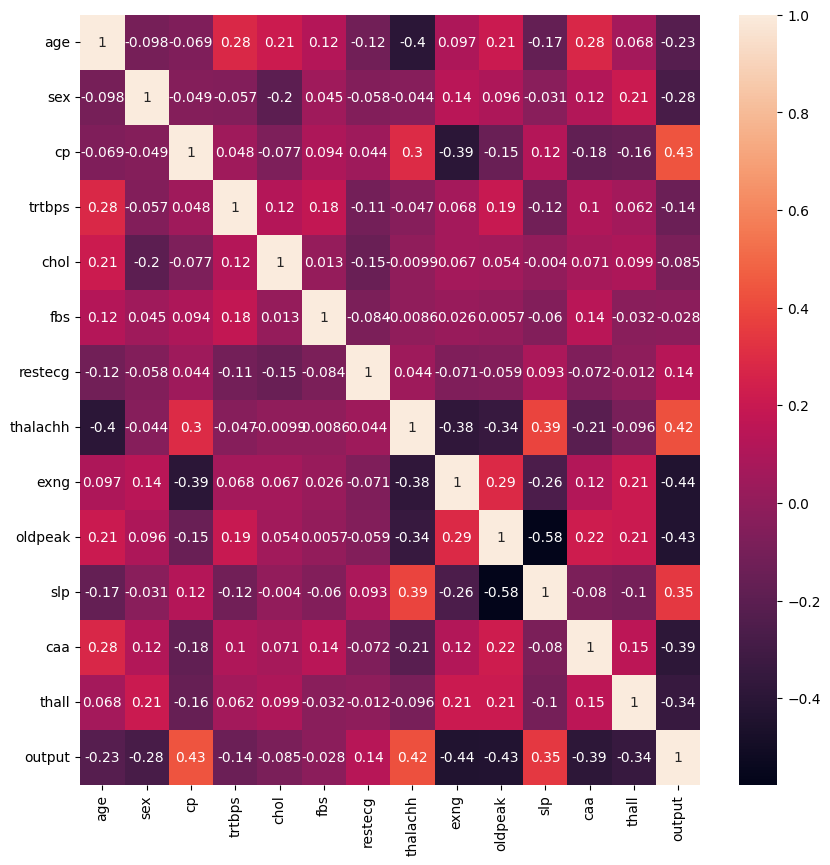

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), annot=True)

In [7]:
# Column names in Snowflake Tables need to be in upper case
data.columns = data.columns.str.upper()
data.columns

Index(['AGE', 'SEX', 'CP', 'TRTBPS', 'CHOL', 'FBS', 'RESTECG', 'THALACHH',
       'EXNG', 'OLDPEAK', 'SLP', 'CAA', 'THALL', 'OUTPUT'],
      dtype='object')

# Data Preparation:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['OUTPUT'])], data['OUTPUT'], test_size=0.2, random_state=42)

In [9]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [10]:
print('Shape of train_df: ', train_df.shape)
print('Shape of test_df: ', test_df.shape)

Shape of train_df:  (242, 14)
Shape of test_df:  (61, 14)


OUTPUT
1    133
0    109
Name: count, dtype: int64


<Axes: xlabel='OUTPUT', ylabel='count'>

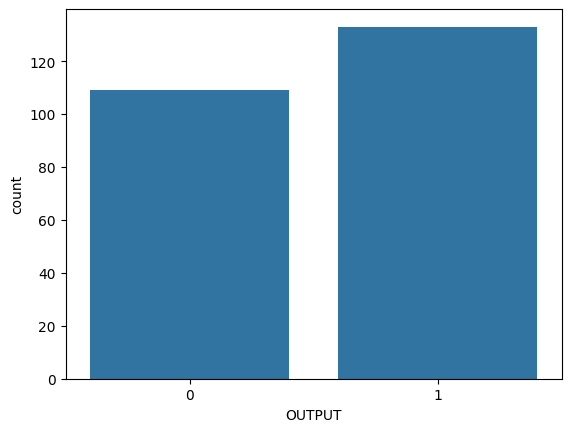

In [11]:
print(train_df['OUTPUT'].value_counts())
sns.countplot(data=train_df, x='OUTPUT')

OUTPUT
1    32
0    29
Name: count, dtype: int64


<Axes: xlabel='OUTPUT', ylabel='count'>

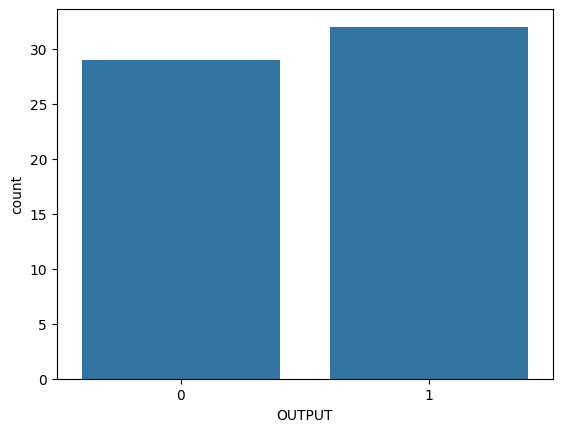

In [12]:
print(test_df['OUTPUT'].value_counts())
sns.countplot(data=test_df, x='OUTPUT')

In [13]:
scaler = StandardScaler()
train_df[train_df.columns.difference(['OUTPUT'])] = scaler.fit_transform(train_df[train_df.columns.difference(['OUTPUT'])])
test_df[test_df.columns.difference(['OUTPUT'])] = scaler.transform(test_df[test_df.columns.difference(['OUTPUT'])])

In [14]:
# Loading data to Snowflake for using Snowflake AI & ML Studio
session.write_pandas(df=train_df, table_name='HEART_ATTACK_CLASSIFICATION_TRAIN_TBL', auto_create_table=True, overwrite=True)
session.write_pandas(df=test_df[test_df.columns.difference(['OUTPUT'])], table_name='HEART_ATTACK_CLASSIFICATION_TEST_TBL', auto_create_table=True, overwrite=True)

In [15]:
# Base model
model = LogisticRegression()
model.fit(X=train_df[train_df.columns.difference(['OUTPUT'])], y=train_df['OUTPUT'])

LogisticRegression()

In [16]:
# Base model prediction
y_hat = model.predict(X=test_df[test_df.columns.difference(['OUTPUT'])])

In [17]:
# Prediction data from classification model in Snowflake AI & ML Studio
predict_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.MY_CLASSIFICATION_2024_08_07"
preds = session.table(predict_tbl).to_pandas()['PREDICTIONS']
y_hat_sf_ml = preds.map(lambda x:int(x[14:15]))

<Axes: >

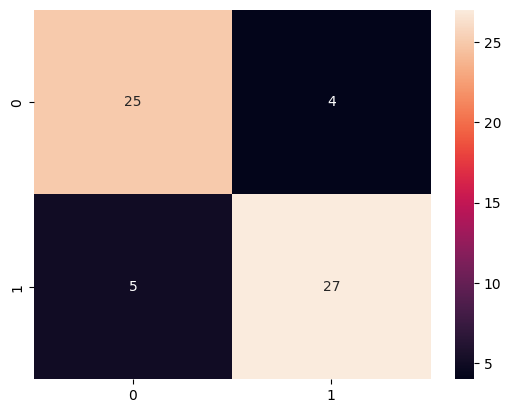

In [18]:
# Confusion matrix of base model
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True)

<Axes: >

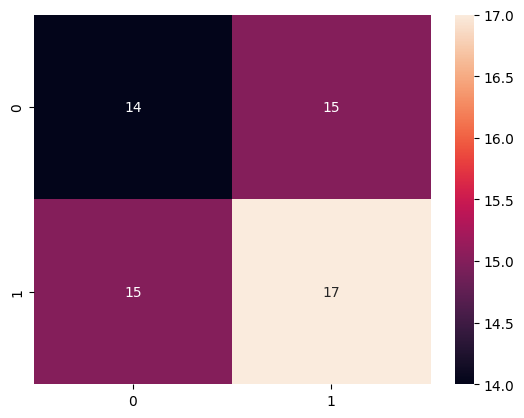

In [19]:
# Confusion matrix of classification model in Snowflake AI & ML Studio
sns.heatmap(confusion_matrix(y_test, y_hat_sf_ml), annot=True)

In [20]:
print('f1_score of base model:', f1_score(y_test, y_hat))
print('f1_score of classification model in Snowflake AI & ML Studio:', f1_score(y_test, y_hat_sf_ml))

f1_score of base model: 0.8571428571428571
f1_score of classification model in Snowflake AI & ML Studio: 0.53125
